# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
January, 2022

## Dimuon mass spectrum calculation with Spark DataFrame API

In [ ]:
#
# Local mode: run this when using CERN SWAN not connected to a cluster 
#             or run it on a private Jupyter notebook instance
#             Dependency: PySpark (use SWAN or pip install pyspark)
#
# For CERN users: when using CERN SWAN connected to a cluster (analytix or cloud resources)
#                 do not run this but rather click on the (star) button

# Start the Spark Session
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("dimuon mass")
         .master("local[*]")
         .config("spark.driver.memory", "2g")
         .config("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")
         .config("spark.ui.showConsoleProgress", "false")
         .getOrCreate()
        )

In [2]:
spark

In [3]:
# Read data with the muon candidate events
# Further details of the available datasets at
# https://github.com/LucaCanali/Miscellaneous/Spark_Physics

# If you don't have access to CERN resources
# Download the data (2 GB) if not yet available locally
# ! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

# Use this path to data when running from SWAN and/or CERN machines with eos mounted
# this will work on CERN Swan when not connected to Spark cluster
path = "/eos/project/s/sparkdltrigger/public/"

# Use this when attached to the analytix Spark cluster at CERN
# path = "hdfs://analytix//project/spark/HEP/"

# Use this with the Hadoop XRootD connector reading from EOS
# it is configured when using the cluster "Spark on K8S" at CERN
# path = "root://eosuser.cern.ch//eos/project/s/sparkdltrigger/public/"

data = "Run2012BC_DoubleMuParked_Muons.parquet"

df_muons = spark.read.parquet(path + data)

df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [4]:
df_muons.limit(10).toPandas()

,nMuon,Muon_pt,Muon_eta,Muon_phi,Muon_mass,Muon_charge
0,2,"[10.763696670532227, 15.736522674560547]","[1.0668272972106934, -0.563786506652832]","[-0.03427272289991379, 2.5426154136657715]","[0.10565836727619171, 0.10565836727619171]","[-1, -1]"
1,2,"[10.538490295410156, 16.327096939086914]","[-0.42778006196022034, 0.34922507405281067]","[-0.2747921049594879, 2.539781332015991]","[0.10565836727619171, 0.10565836727619171]","[1, -1]"
2,1,[3.2753264904022217],[2.210855484008789],[-1.2234135866165161],[0.10565836727619171],[1]
3,4,"[11.429154396057129, 17.634033203125, 9.624728...","[-1.5882395505905151, -1.7511844635009766, -1....","[-2.0773041248321533, 0.25135836005210876, -2....","[0.10565836727619171, 0.10565836727619171, 0.1...","[1, 1, 1, 1]"
4,4,"[3.2834417819976807, 3.64400577545166, 32.9112...","[-2.1724836826324463, -2.18253493309021, -1.12...","[-2.3700082302093506, -2.3051390647888184, -0....","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, -1, 1, 1]"
5,3,"[3.566528081893921, 4.572504043579102, 4.37186...","[-1.371932029724121, -0.703264594078064, -1.03...","[-2.9090449810028076, 2.4552080631256104, -3.0...","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, 1, -1]"
6,2,"[57.6067008972168, 53.04507827758789]","[-0.5320892930030823, -1.0041686296463013]","[-0.07179804146289825, 3.089515209197998]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"
7,2,"[11.31967544555664, 23.906352996826172]","[-0.7716585397720337, -0.700996994972229]","[-2.2452728748321533, -2.1809616088867188]","[0.10565836727619171, 0.10565836727619171]","[1, -1]"
8,2,"[10.19356918334961, 14.204060554504395]","[0.4418068528175354, 0.7021172642707825]","[0.6778520345687866, -2.0344009399414062]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"
9,2,"[11.470704078674316, 3.4690065383911133]","[2.3417420387268066, 2.3523731231689453]","[3.1309704780578613, 3.0211737155914307]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"


In [5]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")


In [6]:
# This computes the 4-vectors sum for the 2 moun system
# using formulas from special relativity, in the limit E >> muons rest mass
# see also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
# and https://en.wikipedia.org/wiki/Invariant_mass

df_with_dimuonmass = df_muons.selectExpr("""
     sqrt(2 * Muon_pt[0] * Muon_pt[1] * 
             ( cosh(Muon_eta[0] - Muon_eta[1]) - cos(Muon_phi[0] - Muon_phi[1]) )
         ) as Dimuon_mass""")

In [7]:
# Compute the histogram of dimuon mass values
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 0.25
max_val = 300
num_bins = 30000
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_with_dimuonmass
        .selectExpr(f"width_bucket(Dimuon_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1) * {step},2) as value", "count as N_events")

In [ ]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


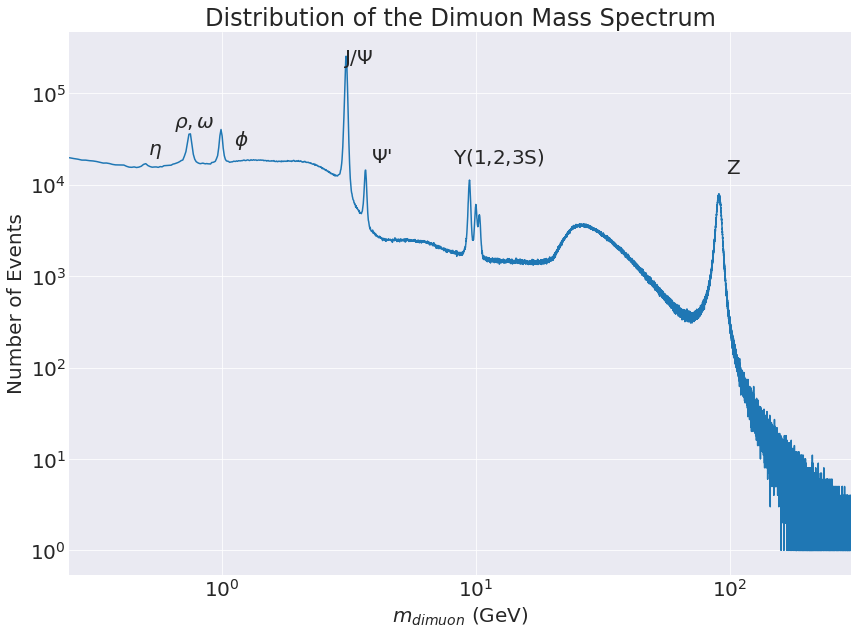

In [9]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
#ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [ ]:
spark.stop()